<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/HuBMAP_image_segmentation_models_20230624.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Medical Image Segmentation references:
# # Read images and mask for train dataset(takes about 30-50 min)
# https://paperswithcode.com/task/medical-image-segmentation
# https://paperswithcode.com/sota/medical-image-segmentation-on-2018-data
# https://github.com/qubvel/segmentation_models

# Faster loading of data with colab
# https://stackoverflow.com/questions/54049440/speed-up-datasets-loading-on-google-colab
# https://joeng03.medium.com/how-to-put-your-google-colab-on-full-steroid-mode-with-7-lines-of-code-more-ram-load-huge-datasets-4e95f1f495e4

# https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/overview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for yolov4: filename=yolov4-3.2.0-cp310-cp310-linux_x86_64.whl size=147404 sha256=81c2b072b2ba3790ff6905d4b33944ddbdd52ff9be43521da0e2d6e3bd242986
  Stored in directory: /root/.cache/pip/wheels/3e/11/2f/84143336f3368a00ba3c7261850dbf6df9764287adb9f1d564
Successfully built yolov4


AttributeError: ignored

In [ ]:
# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_info.csv  masks_grey_bkgrnd	    test	    val_list.csv
images		     masks_white_bkgrnd     test_list.csv   wsi_meta.csv
images_info.csv      polygons.jsonl	    tile_meta.csv
masks		     sample_submission.csv  train_list.csv


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
from PIL import Image


import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm.notebook import tqdm_notebook

%matplotlib inline

In [ ]:
pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
# Import segmentation models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models.utils import set_trainable

Segmentation Models: using `tf.keras` framework.


In [ ]:
# Check versions
print (f'Tensorflow: {tf.__version__}')
print(f'Kears: {keras.__version__}')
print(f'Segmentation Models: {sm.__version__}')
p = !python --version
print(f'Python: {p[0]}')

Tensorflow: 2.12.0
Kears: 2.12.0
Segmentation Models: 1.0.1
Python: Python 3.10.12


In [ ]:
# Make a copy of normalize_he_image.py to current directory
!cp /gdrive/MyDrive/python_modules/normalize_he_image_v2.py .

In [ ]:
# import custom module
import normalize_he_image_v2

In [ ]:
# Image dimension for train, val and test
image_height = 512
image_width = 512
image_channels = 3
num_classes = 4

In [ ]:
annotations_info = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/annotation_info.csv',index_col=0)
annotations_info.head()

,blood_vessel,glomerulus,unsure
0006ff2aa7cd,8,1,0
00168d1b7522,1,1,0
0033bbc76b6b,3,0,1
003504460b3a,7,0,0
004daf1cbe75,9,1,0


In [ ]:
# Load lists assigned for train, val and test
train_list = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/train_list.csv',index_col=0)
val_list = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/val_list.csv',index_col=0)
test_list = pd.read_csv('/gdrive/MyDrive/DATA/HuBMAP/test_list.csv',index_col=0)

In [ ]:
train_list.head()

,train_id
0,18be061202ea
1,29d2f472e46d
2,8f256d18b5e4
3,8e90e6189c6b
4,d850250778f2


In [ ]:
# Create and allocate memory for train, val and test images and masks
# Store image ids for each the thress datasets

train_images = np.zeros((len(train_list[:300]),image_height,image_width,image_channels),
                        dtype=np.uint8)
train_masks = np.zeros((len(train_list[:300]),image_height,image_width),dtype=np.uint8)


#val_images = np.zeros((len(val_list),image_height,image_width,image_channels),
#                      dtype=np.uint8)
#val_masks = np.zeros((len(val_list),image_height,image_width),dtype=np.uint8)
#

#test_images = np.zeros((len(test_list),image_height,image_width,image_channels),
#                       dtype=np.uint8)
#test_masks = np.zeros((len(test_list),image_height,image_width),dtype=np.uint8)



In [ ]:
# Assign path file for images and masks
image_path_file = '/gdrive/MyDrive/DATA/HuBMAP/images/'
mask_path_file = '/gdrive/MyDrive/DATA/HuBMAP/masks/'

In [ ]:
# Read images and mask for train dataset(takes about 30-50 min)
for idx, row in tqdm_notebook(enumerate(train_list[:300].iterrows()),total=len(train_list[:300])):
  id  = row[1]['train_id']
  image = cv2.imread(image_path_file + id + '.tif')
  mask = cv2.imread(mask_path_file + id + '_mask.tif',cv2.IMREAD_GRAYSCALE)

  train_images[idx] = image
  train_masks[idx] = mask

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
print(train_images.shape)
print(train_masks.shape)

(300, 512, 512, 3)
(300, 512, 512)


In [ ]:
annotations_info.loc[train_list.loc[:300,'train_id'],:].sort_values(by='blood_vessel')

,blood_vessel,glomerulus,unsure
18be061202ea,0,0,1
29d2f472e46d,0,0,1
8f256d18b5e4,0,0,4
8e90e6189c6b,0,0,2
d850250778f2,0,0,5
...,...,...,...
611599949a53,30,0,4
e0072029e135,30,0,3
5232ba7fa001,31,0,2
c9a0f19e04c5,34,0,4


In [ ]:
def assign_class_color(mask_input,assign_color=False):

  # If mask is not a numpy (some sort tf eagortensor)
  # convert to numpy array - this is for pre-mask
  if type(mask_input) is not np.ndarray:
    mask_input = np.squeeze(mask_input.numpy(),-1).astype(np.uint8)

  # Color assign each class (background, blood vessel, glomerulus and unsure)
  # a distinct color to be displayed with when viewd
  if assign_color:  # assign different color to all four classes
    palette = [255,255,255,     # 0=white
              255,0,0,          # 1= red
              255,255,0,        # 2=yellow
              0,0,255]          # 3=blue
  else: # assign color only to blood vessels and keep the rest white
    palette = [255,255,255,     # 0= white
              255,0,0,          # 1= red
              255,255,255,      # 2= white
              255,255,255]      # 3= white

  # Pad with zeroes to 768 values, i.e. 256 RGB colours
  palette = palette + [0]*(768-len(palette))

  # Convert Numpy array to palette image
  mask_pi = Image.fromarray(mask_input,'P')

  # Put the palette in
  mask_pi.putpalette(palette)

  return mask_pi

In [ ]:
# Display original images from train_images and their respective masks
# Use num to locate selected image from train_iamges
# Use id to locate mask from directory file masks_4d_alt
def display_images_masks(image_list,image_id=None,
                         image_labels=['Image','Mask','Pred. Mask']):

  print(f"Annotation counts for image: {image_id}: \
  bood vessel: {annotations_info.loc[image_id,'blood_vessel']}, \
  glomerulus: {annotations_info.loc[image_id,'glomerulus']}, \
  unsure: {annotations_info.loc[image_id,'unsure']}.")

  plt.figure(figsize=(10,10))
  for idx,img in enumerate(image_list):
    plt.subplot(1,len(image_list),idx+1)
    plt.imshow(image_list[idx])
    plt.title(f'{image_labels[idx]}: {image_id}') if idx == 0 else plt.title(f'{image_labels[idx]}')
    plt.xticks([])
    plt.yticks([])

  plt.show()

Annotation counts for image: 65fcbb5ef4c7:   bood vessel: 4,   glomerulus: 0,   unsure: 2.


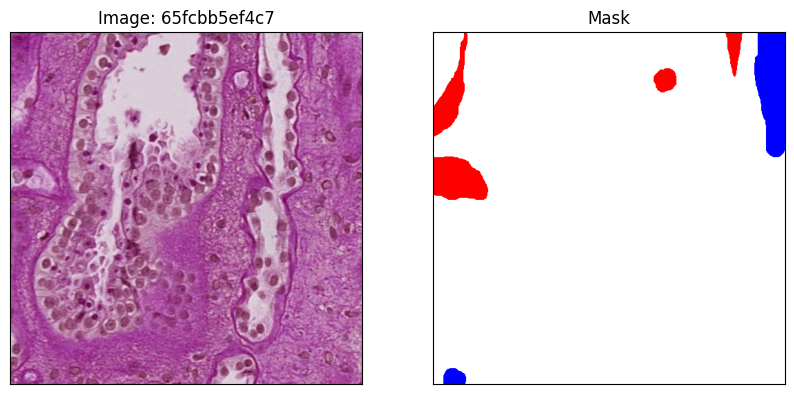

Annotation counts for image: e0072029e135:   bood vessel: 30,   glomerulus: 0,   unsure: 3.


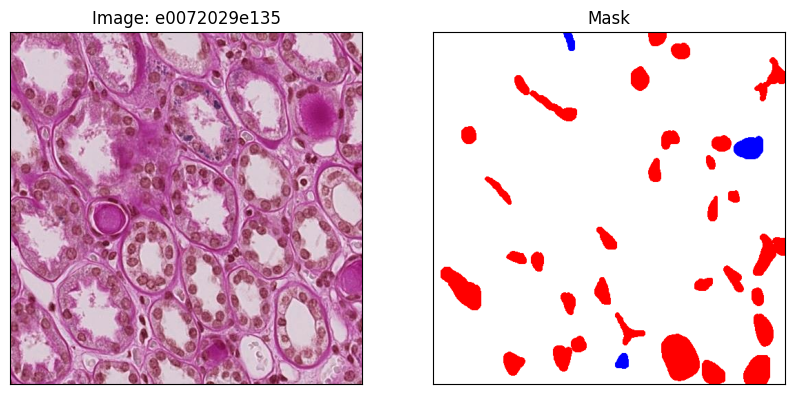

Annotation counts for image: 9cbdd3eb5929:   bood vessel: 5,   glomerulus: 0,   unsure: 2.


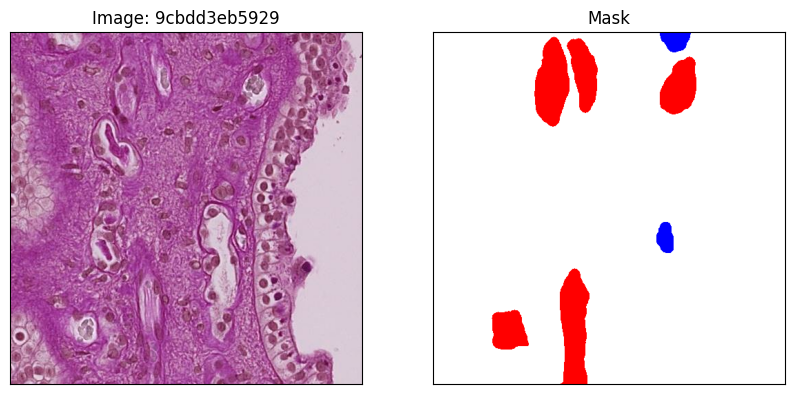

In [ ]:
# Display original images and their respective masks
for _ in range(3):
  num = np.random.randint(0,len(train_images))
  id = train_list.loc[num,'train_id']
  image = train_images[num]
  mask = assign_class_color(train_masks[num],True)
  display_images_masks([image,mask],id)

In [ ]:
#4b71f2e1d1ba
idx = train_list[train_list.train_id == '4b71f2e1d1ba'].index[0]
np.unique(train_masks[idx])

array([0, 1, 3], dtype=uint8)

In [ ]:
# Normalize H&E color for the image
# Also can generated hematoxilyn (h) color separated and eosin (e) color separated
# image
def normalize_image_color(image):

  norm_image,h,e = normalize_he_image_v2.normalize_HnE_stain(image)

  return e

In [ ]:
# Store normalized H&E color images in separate numpy arrays
train_images_norm = np.zeros((len(train_images[:300]),image_height,image_width,image_channels),
                                 dtype=np.uint8)

In [ ]:
# Normalize H&E color for the images

for idx in tqdm_notebook(range(len(train_images[:300])),total=len(train_images[:300])):
  train_images_norm[idx] = normalize_image_color(train_images[idx])

  0%|          | 0/300 [00:00<?, ?it/s]

Annotation counts for image: 27ac6c438f3b:   bood vessel: 1,   glomerulus: 0,   unsure: 2.


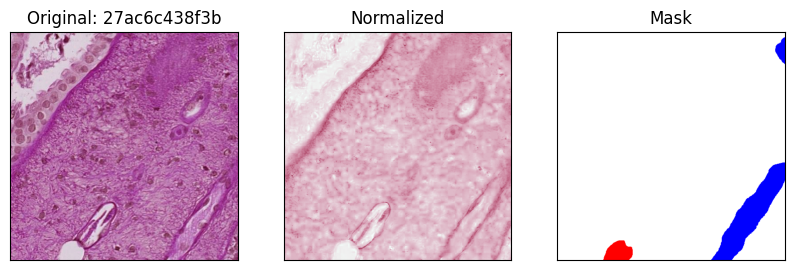

Annotation counts for image: bd4bbe103c24:   bood vessel: 8,   glomerulus: 0,   unsure: 1.


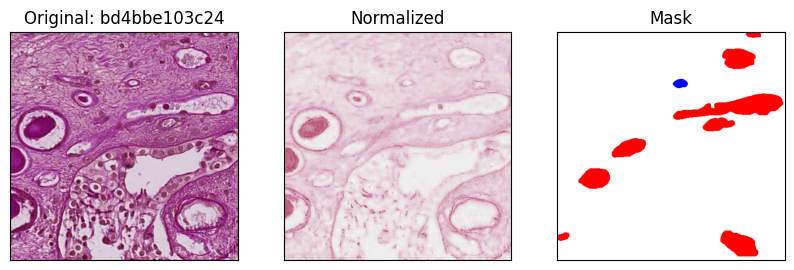

Annotation counts for image: a4b58c23d4c6:   bood vessel: 3,   glomerulus: 0,   unsure: 4.


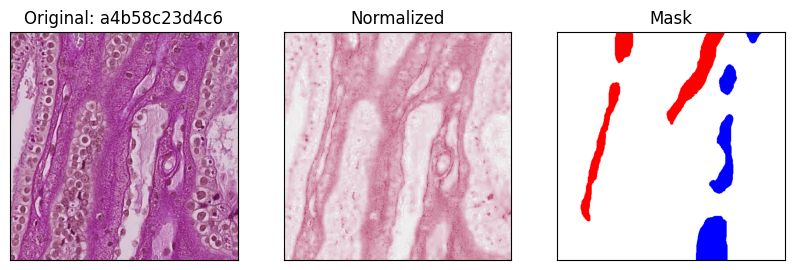

In [ ]:
# Display original and color normalize iamges, and mask
for _ in range(3):
  num = np.random.randint(0,len(train_images))
  id = train_list.loc[num,'train_id']
  image_orig = train_images[num]
  image_norm = train_images_norm[num]
  mask = assign_class_color(train_masks[num],True)
  display_images_masks([image_orig,image_norm,mask],id,['Original','Normalized','Mask'])

In [ ]:
# Resize image and mask height and width
# and normalize image pixel to 0 to 1
def resize_normalize(image_input,mask_input):

  image_res = cv2.resize(image_input,dsize=(128,128),
                         interpolation=cv2.INTER_NEAREST)
  mask_res = cv2.resize(mask_input,dsize=(128,128),
                    interpolation=cv2.INTER_NEAREST)

  # use this with own custom model
  #image_norm = image_res / 254.  # may need to change this to 254

  return image_res, mask_res

In [ ]:
# Allocate memory for numpy array for images are normalized for H&E color
# resized and pixels normalized between 0 and 1
train_images_norm_res = np.zeros((len(train_images[:300]),128,128,image_channels),
                                 dtype= np.uint8)  # np.float64
train_masks_res = np.zeros((len(train_images[:300]),128,128),
                                 dtype= np.uint8)

In [ ]:
for idx in range(len(train_images_norm)):
  train_images_norm_res[idx],train_masks_res[idx]= resize_normalize(
      train_images_norm[idx],train_masks[idx])


In [ ]:
print(f'train_iamges_norm_res shape: {train_images_norm_res.shape}.')
print(f'train_masks_res shape: {train_masks_res.shape}.')

train_iamges_norm_res shape: (300, 128, 128, 3).
train_masks_res shape: (300, 128, 128).


Annotation counts for image: 327dcb16a7ef:   bood vessel: 4,   glomerulus: 1,   unsure: 3.


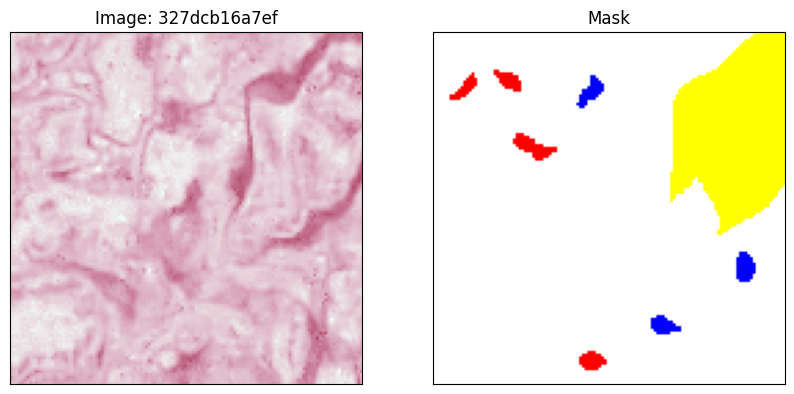

Annotation counts for image: 65e7ca00c422:   bood vessel: 6,   glomerulus: 0,   unsure: 2.


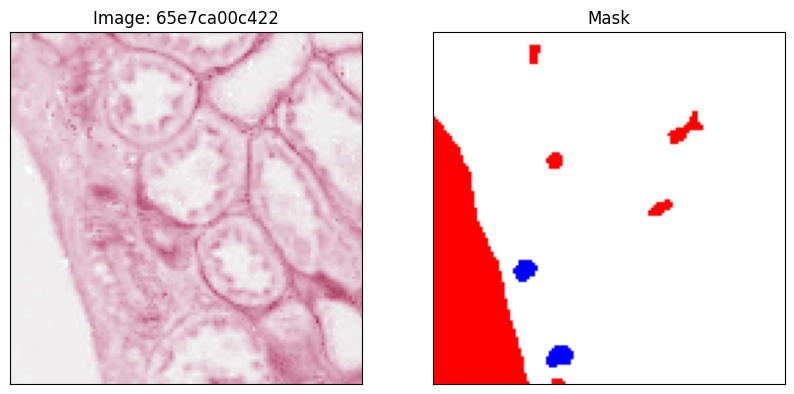

Annotation counts for image: 31195284c86e:   bood vessel: 1,   glomerulus: 0,   unsure: 3.


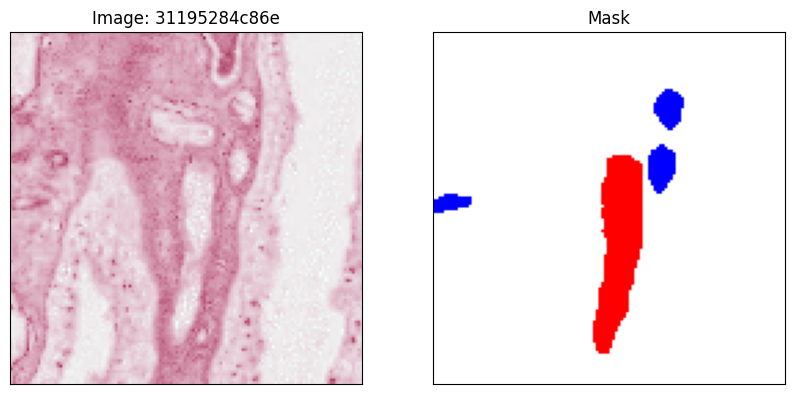

In [ ]:
# Display images and masks
# Display original and color normalize iamges, and mask
for _ in range(3):
  num = np.random.randint(0,len(train_images))
  id = train_list.loc[num,'train_id']

  image_norm_res = train_images_norm_res[num]
  mask = assign_class_color(train_masks_res[num],True)
  display_images_masks([image_norm_res,mask],id)

In [ ]:
print(f'train_images_norm_res min: {train_images_norm_res.min()} & max: {train_images_norm_res.max()}')
#np.unique(train_images_norm_res[0])

train_images_norm_res min: 3 & max: 254


In [ ]:
# Expand mask dimension
train_masks_cat = np.expand_dims(train_masks_res.copy(),axis=-1)
#val_masks = np.expand_dims(val_masks,axis=-1)
#test_masks = np.expand_dims(test_masks,axis=-1)

In [ ]:
# Convert masks/labels to categorical (onehot encode)
train_masks_cat = to_categorical(train_masks_cat,num_classes)
#Y_val_cat = to_categorical(val_masks.copy(), num_classes)
#Y_test_cat = to_categorical(test_masks.copy(),num_classes)

Annotation counts for image: 4b71f2e1d1ba:   bood vessel: 20,   glomerulus: 0,   unsure: 4.


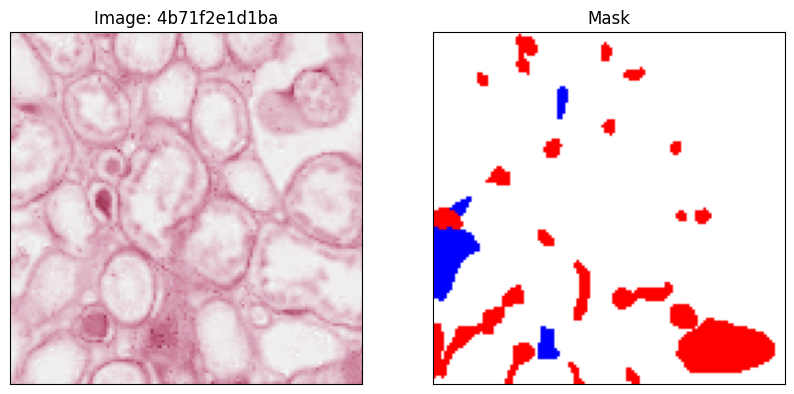

In [ ]:
# Display images and masks during training
num = np.random.randint(0,len(train_images))
id = train_list.loc[num,'train_id']

sample_image = train_images_norm_res[num]
sample_mask = assign_class_color(train_masks_res[num],True)

display_images_masks([sample_image,sample_mask],id)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  prediction = current_model.predict(sample_image[tf.newaxis, ...])
  predicted_mask = create_mask(prediction)

  pred_mask = assign_class_color(predicted_mask,True)

  display_images_masks([sample_image, sample_mask,pred_mask],id)

In [ ]:
# Display image, mask and prediction mask after each epoch
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
!ls /gdrive/MyDrive/saved_models/HuBMAP/

checkpoint			    test_unet_segmodel.ckpt.data-00000-of-00001
test_unet.ckpt.data-00000-of-00001  test_unet_segmodel.ckpt.index
test_unet.ckpt.index


In [ ]:
saved_model_filepath = "/gdrive/MyDrive/saved_models/HuBMAP/test_unet_segmodel.ckpt"

earlystopper = EarlyStopping(patience=3, verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=saved_model_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)


callback_list = [earlystopper,checkpoint,DisplayCallback()]

In [ ]:
def show_history(model_history):
  print(f'{model_history.history.keys()}')

  var = list(model_history.history.keys())
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  mean_iou = model_history.history[var[1]]
  val_mean_iou = model_history.history[var[-2]]

  iou = model_history.history[var[2]]
  val_iou = model_history.history[var[-1]]

  epochs_range = model_history.epoch

  plt.figure(figsize=(14, 6))
  plt.subplot(1, 3, 1)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


  plt.subplot(1, 3, 2)
  plt.plot(epochs_range, mean_iou, label='Training MeanIoU')
  plt.plot(epochs_range, val_mean_iou, label='Validation MeanIoU')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Mean IoU')

  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, iou, label='Training IoU')
  plt.plot(epochs_range, val_iou, label='Validation IoU')
  plt.legend(loc='lower right')
  plt.title('Training and Validation IoU')


  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]
  train_meanIoU = model_history.history[var[1]][-1]
  val_meanIoU = model_history.history[var[-1]][-1]

  print(f'Training loss: {train_loss:.3f}\tTraining meanIoU: {train_meanIoU:.3f}')
  print(f'Validation loss: {val_loss:.3f}\tValidation meanIoU: {val_meanIoU:.3f}')


In [ ]:
# Reusable model parameters
activation_input_1 = 'softmax'

LR_1 = 0.0001

optim_1 = keras.optimizers.Adam(learning_rate=LR_1)


# Use Jaccard and categorical focal loss
loss_1 = sm.losses.JaccardLoss() + sm.losses.CategoricalFocalLoss()

metrics_input_1 = [tf.keras.metrics.MeanIoU(num_classes=4,
                                            sparse_y_pred = False,
                                            sparse_y_true= False),
                   tf.keras.metrics.IoU(num_classes=4,target_class_ids = [1],
                                            sparse_y_pred = False,
                                            sparse_y_true= False)]

In [ ]:
def create_model(backbone_input,optimizer_input,loss_input,freeze_encoder=False):
    model = sm.Unet(backbone_input,
                  encoder_weights='imagenet',
                  activation=activation_input_1,
                  classes=num_classes,
                  input_shape=(128,128,image_channels),
                  encoder_freeze=freeze_encoder)

    model.compile(optimizer=optimizer_input,
                  loss=loss_input,
                  metrics=metrics_input_1)

    return model


In [ ]:
#### Model # 1
BACKBONE_1 = 'vgg19'
preprocess_input_1 = sm.get_preprocessing(BACKBONE_1)

# preprocess input
X_train_p1 = preprocess_input_1(train_images_norm_res.copy())
#X_val_p1 = preprocess_input_1(X_val.copy())
#X_test_p1 = preprocess_input_1(X_test.copy())

In [ ]:
print(f'Min: {X_train.min()} and Max: {X_train.max()}')

Min: -115.77899932861328 and Max: 150.06100463867188


In [ ]:
model_1 = create_model(BACKBONE_1,optim_1,loss_1)
current_model = model_1

1/1 [==============================] - 0s 382ms/step
Annotation counts for image: 3e01bb974a1b:   bood vessel: 9,   glomerulus: 1,   unsure: 2.


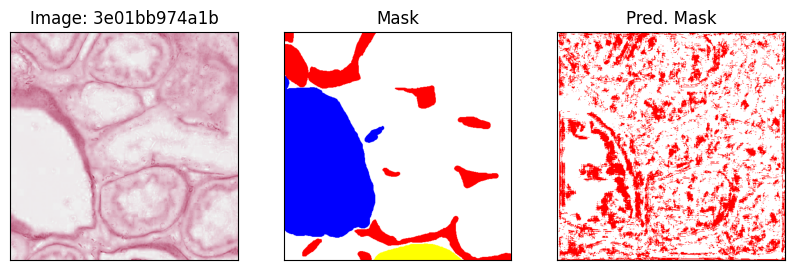

In [ ]:
#sample_mask = assign_class_color(sample_mask,True)
show_predictions()

1/1 [==============================] - 0s 24ms/step
Annotation counts for image: 3e01bb974a1b:   bood vessel: 9,   glomerulus: 1,   unsure: 2.


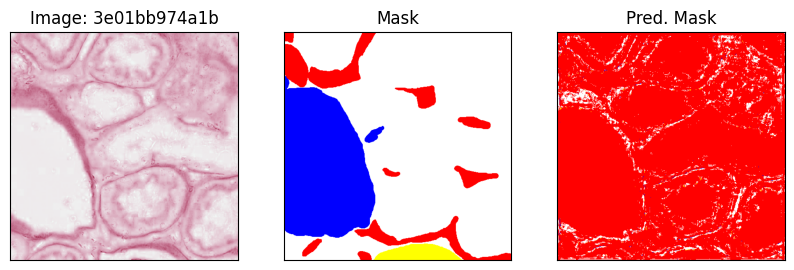


Sample Prediction after epoch 20

14/14 [==============================] - 6s 400ms/step - loss: 0.8293 - mean_io_u_3: 0.1981 - io_u_3: 0.0826 - val_loss: 0.8565 - val_mean_io_u_3: 0.1862 - val_io_u_3: 0.0865
Epoch 20: early stopping


In [ ]:
# Train model
history_1 = current_model.fit(X_train_p1[:270],
            train_masks_cat[:270],
            batch_size=20,
            epochs=30,
            verbose=1,
            validation_data=(X_train_p1[270:],train_masks_cat[270:]),
            callbacks=callback_list)

In [ ]:
# ============================================================================================

In [ ]:
#### Model # 2
BACKBONE_2 = 'efficientnetb7'
preprocess_input_2 = sm.get_preprocessing(BACKBONE_2)

# preprocess input
X_train_p2 = preprocess_input_2(train_images_norm_res.copy())
#X_val_p1 = preprocess_input_1(X_val.copy())
#X_test_p1 = preprocess_input_1(X_test.copy())

In [ ]:
print(f'Min: {X_train_p2.min()} and Max: {X_train_p2.max()}')

Min: -1.983193278312683 and Max: 2.6225709915161133


In [ ]:
model_2 = create_model(BACKBONE_2,optim_1,loss_1)
current_model = model_2

1/1 [==============================] - 13s 13s/step
Annotation counts for image: 4b71f2e1d1ba:   bood vessel: 20,   glomerulus: 0,   unsure: 4.


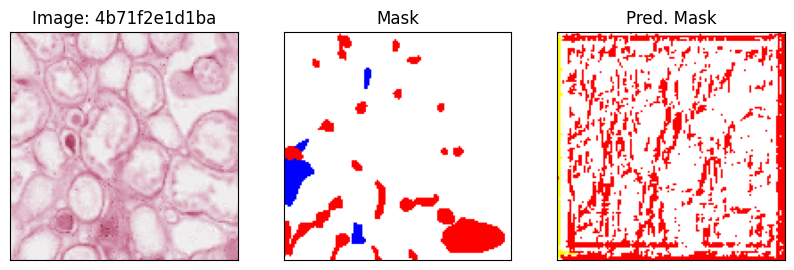

In [ ]:
#sample_mask = assign_class_color(sample_mask,True)
show_predictions()

1/1 [==============================] - 0s 47ms/step
Annotation counts for image: 4b71f2e1d1ba:   bood vessel: 20,   glomerulus: 0,   unsure: 4.


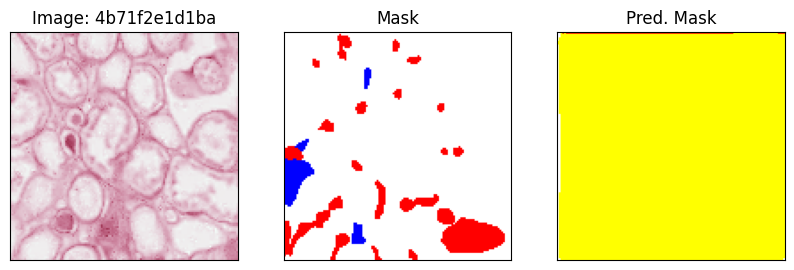


Sample Prediction after epoch 27

14/14 [==============================] - 3s 192ms/step - loss: 0.5194 - mean_io_u: 0.6170 - io_u: 0.7047 - val_loss: 0.7530 - val_mean_io_u: 0.2712 - val_io_u: 0.1653
Epoch 27: early stopping


In [ ]:
# Train model
history_2 = model_2.fit(X_train_p2[:270],
            train_masks_cat[:270],
            batch_size=20,
            epochs=30,
            verbose=1,
            validation_data=(X_train_p2[270:],train_masks_cat[270:]),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u', 'io_u', 'val_loss', 'val_mean_io_u', 'val_io_u'])
Training loss: 0.519	Training meanIoU: 0.617
Validation loss: 0.753	Validation meanIoU: 0.165


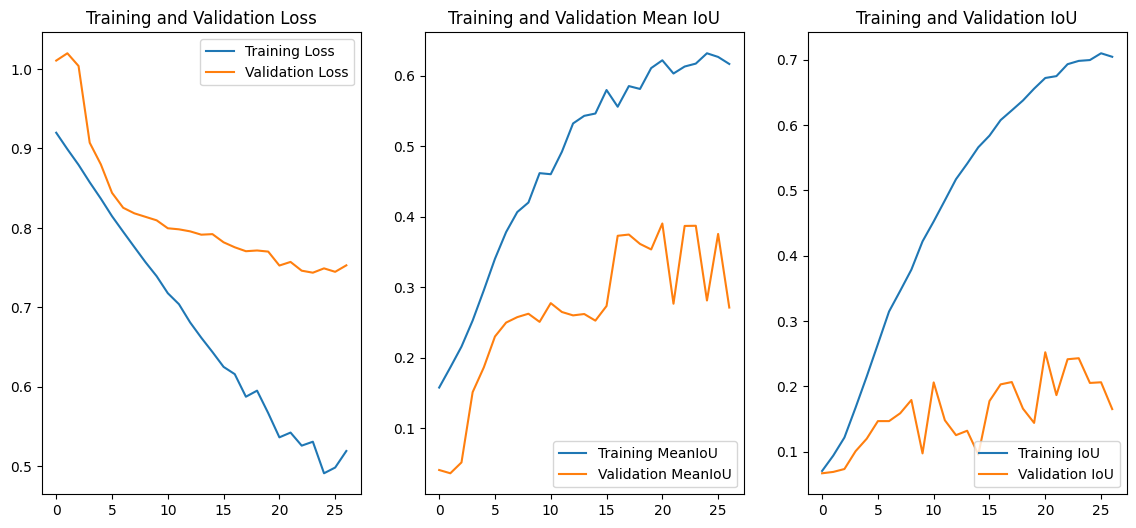

In [ ]:
show_history(history_2)